# Thasina Tabashum
# Farhad Mokter

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import time

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [3]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

65 unique characters


In [6]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [7]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [8]:
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


In [9]:
seq_length = 100
examples_per_epoch = len(text)

In [10]:
# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

F
i
r
s
t


In [11]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [12]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [13]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [14]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')


In [15]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [16]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [17]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [130]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [131]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [20]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [22]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [23]:
sampled_indices

array([54, 41, 32,  5, 61, 19,  3, 35, 25, 16,  2, 44, 58, 38, 62, 16, 22,
       40, 43, 18, 60,  1, 32, 14, 13, 27, 33, 24, 55,  6, 61,  8, 29, 22,
       10, 53, 16,  0,  4, 23, 63, 47,  7, 32, 17, 24, 42, 57,  5, 59, 42,
       15, 52, 62, 41,  6, 25, 40, 64, 61, 59,  2, 33, 47, 20, 62, 23,  7,
       13, 17, 55, 49, 21, 57, 19, 48, 35, 63, 35, 19,  3, 56, 53, 45, 39,
       33, 29, 46, 50, 19, 57, 18,  4, 42, 59, 53, 43, 61, 10, 58],
      dtype=int64)

In [24]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'to thee shall be my study, and my profit\ntherein the heaping friendships. Of that fatal\ncountry, Sic'

Next Char Predictions: 
 "pcT'wG$WMD!ftZxDJbeFv TBAOULq,w.QJ:oD\n&Kyi-TELds'udCnxc,Mbzwu!UiHxK-AEqkIsGjWyWG$rogaUQhlGsF&duoew:t"


In [25]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.1747746


In [26]:
model.compile(optimizer='adam', loss=loss)

In [28]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [86]:
EPOCHS=10

In [87]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train for 172 steps
Epoch 1/10
172/172 [==============================] - 239s 1s/step - loss: 2.4754
Epoch 2/10
172/172 [==============================] - 243s 1s/step - loss: 1.9331
Epoch 3/10
172/172 [==============================] - 245s 1s/step - loss: 1.6814
Epoch 4/10
172/172 [==============================] - 249s 1s/step - loss: 1.5386
Epoch 5/10
172/172 [==============================] - 252s 1s/step - loss: 1.4517
Epoch 6/10
172/172 [==============================] - 249s 1s/step - loss: 1.3928
Epoch 7/10
172/172 [==============================] - 250s 1s/step - loss: 1.3483
Epoch 8/10
172/172 [==============================] - 235s 1s/step - loss: 1.3096
Epoch 9/10
172/172 [==============================] - 235s 1s/step - loss: 1.2759
Epoch 10/10
172/172 [==============================] - 236s 1s/step - loss: 1.2427


In [29]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints\\ckpt_10'

In [30]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [32]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [33]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: he doth damn dews:
Swell so much to three battless Townr hath paled
With tends such father, fellows have; prepostering hite.
FartIUS:
Hen she durst wince that singuless clear
Has there, to purpose must. His raje to break them, live
Lad has put in thee, take themoster; if your battle looks,
I could say a few word and by my erges:
At the world I blast too, bring me little vols was:
The worsher laid or time, not any upproverbid,
Hast thou, give him. I have avide!

QUEEN ELIZABETH:
By the northere, very tomongs, so till they know no more strong hath jost before him;
And to Our house:
And heish one war nor hath their plain stabb'd your paper.
And, of firtt to thee sweet; to pread it,
That up Northumberland's most royal kiss,
That naught have strong a person read.

MARCIUS:
Nay, I hear upon my blood,
You have empounded vary marrian wishing hither;
And put you may the sacred vault,
I'll raised villains they are too cauntaily?

PRINCEPERET:
What, wish! the scandon your country may must 

# LSTM

In [34]:
def build_model_lstm(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [35]:
model2 = build_model_lstm(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [36]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense_2 (Dense)              (64, None, 65)            66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


In [37]:
model2.compile(optimizer='adam', loss=loss)

In [38]:
# Directory where the checkpoints will be saved
checkpoint_dir2 = './training_checkpoints_lstm'
# Name of the checkpoint files
checkpoint_prefix2 = os.path.join(checkpoint_dir2, "ckpt_{epoch}")

checkpoint_callback2=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix2,
    save_weights_only=True)

In [99]:
history3 = model2.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback2])

Train for 172 steps
Epoch 1/10
172/172 [==============================] - 312s 2s/step - loss: 2.4616
Epoch 2/10
172/172 [==============================] - 315s 2s/step - loss: 1.8867
Epoch 3/10
172/172 [==============================] - 339s 2s/step - loss: 1.6533
Epoch 4/10
172/172 [==============================] - 313s 2s/step - loss: 1.5212
Epoch 5/10
172/172 [==============================] - 316s 2s/step - loss: 1.4406
Epoch 6/10
172/172 [==============================] - 321s 2s/step - loss: 1.3842
Epoch 7/10
172/172 [==============================] - 318s 2s/step - loss: 1.3402
Epoch 8/10
172/172 [==============================] - 316s 2s/step - loss: 1.3016
Epoch 9/10
172/172 [==============================] - 318s 2s/step - loss: 1.2688
Epoch 10/10
172/172 [==============================] - 317s 2s/step - loss: 1.2347


In [39]:
tf.train.latest_checkpoint(checkpoint_dir2)

'./training_checkpoints_lstm\\ckpt_10'

In [40]:
model2 = build_model_lstm(vocab_size, embedding_dim, rnn_units, batch_size=1)

model2.load_weights(tf.train.latest_checkpoint(checkpoint_dir2))

model2.build(tf.TensorShape([1, None]))

# Comparing between two models

In [ ]:
model1_loss = history.history['loss']
model2_loss = history3.history['loss']

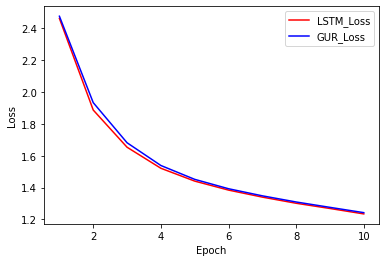

In [114]:
import matplotlib.pyplot as plt

epoch_count = range(1, len(model1_loss)+1)

# Visualize loss history
plt.plot(epoch_count, model2_loss, 'r-')
plt.plot(epoch_count, model1_loss, 'b-')
plt.legend(['LSTM_Loss','GUR_Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Names Dataset

In [115]:
names_file = open("names.txt",encoding='utf-8').read()

In [116]:
print ('Length of text: {} characters'.format(len(names_file)))

Length of text: 1284899 characters


In [117]:
print(names_file[:100])

--------------------
a'isha
a'ishah
a-jay
aa'isha
aa'ishah
aaban
aabas
aabha
aabia
aabid
aabidah
aab


In [118]:
vocab = sorted(set(names_file))
print ('{} unique characters'.format(len(vocab)))

137 unique characters


In [119]:
# Creating a mapping from unique characters to indices
char2idx_n = {u:i for i, u in enumerate(vocab)}
idx2char_n = np.array(vocab)

text_as_int_n = np.array([char2idx_n[c] for c in names_file])

In [120]:
print('{')
for char,_ in zip(char2idx_n, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx_n[char]))
print('  ...\n}')

{
  '\n':   0,
  '&' :   1,
  "'" :   2,
  '(' :   3,
  ')' :   4,
  '-' :   5,
  '/' :   6,
  '0' :   7,
  '8' :   8,
  '[' :   9,
  'a' :  10,
  'b' :  11,
  'c' :  12,
  'd' :  13,
  'e' :  14,
  'f' :  15,
  'g' :  16,
  'h' :  17,
  'i' :  18,
  'j' :  19,
  ...
}


In [121]:
print ('{} ---- characters mapped to int ---- > {}'.format(repr(names_file[:13]), text_as_int_n[:13]))

'-------------' ---- characters mapped to int ---- > [5 5 5 5 5 5 5 5 5 5 5 5 5]


In [138]:
seq_length = 10
examples_per_epoch = len(text)

In [139]:
char_dataset_n = tf.data.Dataset.from_tensor_slices(text_as_int_n)

for i in char_dataset_n.take(5):
  print(idx2char_n[i.numpy()])

-
-
-
-
-


In [140]:
sequences = char_dataset_n.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char_n[item.numpy()])))

'-----------'
'---------\na'
"'isha\na'ish"
'ah\na-jay\naa'
"'isha\naa'is"


In [180]:
def split_input_target_names(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset_n = sequences.map(split_input_target_names)

In [181]:
for input_example, target_example in  dataset_n.take(1):
  print ('Input data: ', repr(''.join(idx2char_n[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char_n[target_example.numpy()])))

Input data:  '----------'
Target data: '----------'


In [182]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char_n[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char_n[target_idx])))

Step    0
  input: 5 ('-')
  expected output: 5 ('-')
Step    1
  input: 5 ('-')
  expected output: 5 ('-')
Step    2
  input: 5 ('-')
  expected output: 5 ('-')
Step    3
  input: 5 ('-')
  expected output: 5 ('-')
Step    4
  input: 5 ('-')
  expected output: 5 ('-')


In [183]:
# Batch size
BATCH_SIZE = 256

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset_n = dataset_n.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [184]:
# Length of the vocabulary in chars
vocab_size_n = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [185]:
def build_model_new(vocab_size_n, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size_n, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size_n)
  ])
  return model

In [186]:
model_new = build_model_new(
  vocab_size_n = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [193]:
for input_example_batch, target_example_batch in dataset_n.take(1):
  example_batch_predictions = model_new(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(256, 10, 137) # (batch_size, sequence_length, vocab_size)


In [194]:
model_new.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (256, None, 256)          35072     
_________________________________________________________________
gru_9 (GRU)                  (256, None, 1024)         3938304   
_________________________________________________________________
dense_11 (Dense)             (256, None, 137)          140425    
Total params: 4,113,801
Trainable params: 4,113,801
Non-trainable params: 0
_________________________________________________________________


In [195]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [196]:
sampled_indices

array([ 56,  82,  77,  30,  47,  54,  96, 107,  44,   7], dtype=int64)

In [198]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (256, 10, 137)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.9228454


In [199]:
model_new.compile(optimizer='adam', loss=loss)

In [200]:
# Directory where the checkpoints will be saved
checkpoint_dir_n = './training_checkpoints_names'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback_n=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [201]:
EPOCHS=10

In [203]:
history_new = model_new.fit(dataset_n, epochs=EPOCHS, callbacks=[checkpoint_callback_n])

Train for 456 steps
Epoch 1/10
456/456 [==============================] - 168s 369ms/step - loss: 2.4928
Epoch 2/10
456/456 [==============================] - 174s 382ms/step - loss: 2.2502
Epoch 3/10
456/456 [==============================] - 170s 372ms/step - loss: 2.1630
Epoch 4/10
456/456 [==============================] - 173s 380ms/step - loss: 2.1024
Epoch 5/10
456/456 [==============================] - 187s 410ms/step - loss: 2.0598
Epoch 6/10
456/456 [==============================] - 174s 382ms/step - loss: 2.0294
Epoch 7/10
456/456 [==============================] - 175s 384ms/step - loss: 2.0059
Epoch 8/10
456/456 [==============================] - 173s 380ms/step - loss: 1.9881
Epoch 9/10
456/456 [==============================] - 175s 384ms/step - loss: 1.9726
Epoch 10/10
456/456 [==============================] - 177s 387ms/step - loss: 1.9618


In [205]:
tf.train.latest_checkpoint(checkpoint_dir_n)

'./training_checkpoints_names\\ckpt_10'

In [206]:
model_new = build_model(vocab_size_n, embedding_dim, rnn_units, batch_size=1)

model_new.load_weights(tf.train.latest_checkpoint(checkpoint_dir_n))

model_new.build(tf.TensorShape([1, None]))

In [207]:
model_new.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (1, None, 256)            35072     
_________________________________________________________________
gru_10 (GRU)                 (1, None, 1024)           3938304   
_________________________________________________________________
dense_12 (Dense)             (1, None, 137)            140425    
Total params: 4,113,801
Trainable params: 4,113,801
Non-trainable params: 0
_________________________________________________________________


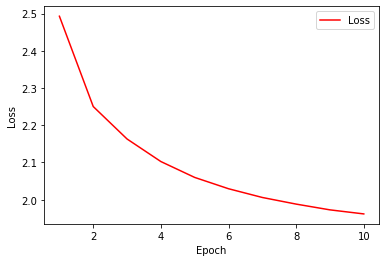

In [210]:
epoch_count = range(1, len(history_new.history['loss'])+1)

# Visualize loss history
plt.plot(epoch_count, history_new.history['loss'], 'r-')

plt.legend(['Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()